In [18]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict

# Definicje

In [19]:
env = gym.make("Blackjack-v1", natural = True, sab=False)

# Hiperparametry
num_episodes = 50_000
gamma = 1.0  # discount factor
epsilon = 0.1 # eksploracja

In [20]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))
returns_count = defaultdict(lambda: np.zeros(env.action_space.n))

# Pomocnicze funkcje

In [21]:
def basic_strategy(state):
    player_sum, dealer_card, usable_ace = state
    if player_sum >= 17:
        return 0  # stick
    else:
        return 1  # hit

def choose_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])
    

def mc_policy(state):
    return np.argmax(Q[state])


In [22]:
def evaluate_policy(policy_fn, n_games=100_000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(n_games):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    return wins, losses, draws

# Trenowanie agenta

In [23]:
rewards_history = []
for episode in range(num_episodes):
    episode_memory = []
    state, _ = env.reset()
    done = False

    while not done:
        action = choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_memory.append((state, action, reward))
        state = next_state

    rewards_history.append(reward)

    G = 0
    visited = set()
    for state, action, reward in reversed(episode_memory):
        G = reward + gamma * G
        if (state, action) not in visited:
            returns_count[state][action] += 1
            Q[state][action] += (G - Q[state][action]) / returns_count[state][action]
            visited.add((state, action))

    if (episode + 1) % 10000 == 0:
        print(f"episode {episode+1}/{num_episodes}")


episode 10000/50000
episode 20000/50000
episode 30000/50000
episode 40000/50000
episode 50000/50000


# Porównanie z klasyczną

In [24]:
wins_q, losses_q, draws_q = evaluate_policy(mc_policy)
wins_bs, losses_bs, draws_bs = evaluate_policy(basic_strategy)

print("Monte carlo: Wins:", wins_q, "Losses:", losses_q, "Draws:", draws_q)
print("Basic Strategy: Wins:", wins_bs, "Losses:", losses_bs, "Draws:", draws_bs)

Monte carlo: Wins: 42146 Losses: 49365 Draws: 8489
Basic Strategy: Wins: 40749 Losses: 48856 Draws: 10395


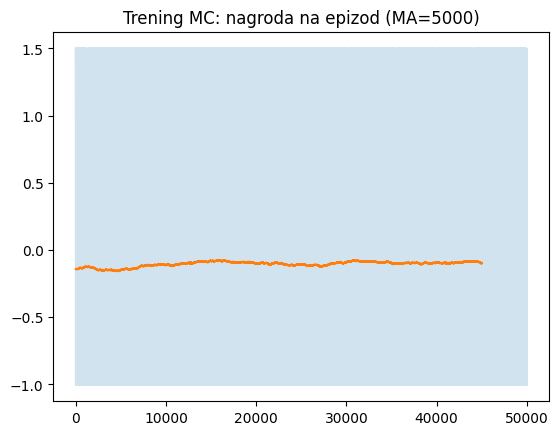

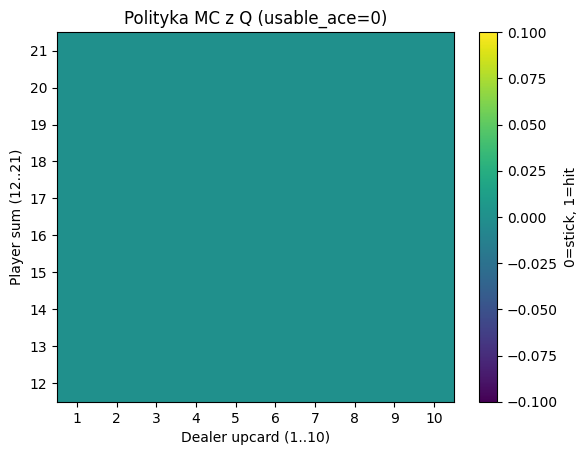

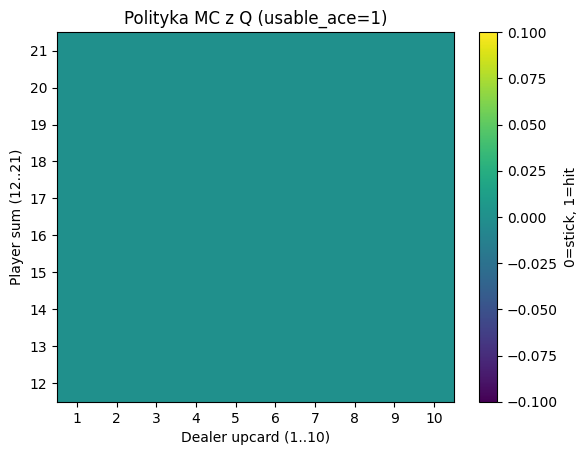

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(x, w):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w, dtype=np.float32)/w, mode="valid")

# --- rewards ---
rewards = None
for name in ["episode_rewards", "episode_rewards_history", "rewards_history"]:
    if name in globals():
        rewards = np.asarray(globals()[name], dtype=np.float32)
        break

if rewards is not None:
    plt.figure()
    plt.plot(rewards, alpha=0.2)
    plt.plot(moving_avg(rewards, 5000))
    plt.title("Trening MC: nagroda na epizod (MA=5000)")
    plt.show()


def plot_policy_heatmap_from_Q(Q, usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))

    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            q_stick = Q.get((s, d, usable_ace, 0), 0.0)
            q_hit   = Q.get((s, d, usable_ace, 1), 0.0)
            grid[i, j] = int(q_hit > q_stick)

    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"Polityka MC z Q (usable_ace={usable_ace})")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum (12..21)")
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar(label="0=stick, 1=hit")
    plt.show()

def plot_value_heatmap(V, usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))

    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            grid[i, j] = V.get((s, d, usable_ace), 0.0)

    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"V(s) MC (usable_ace={usable_ace})")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum (12..21)")
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar()
    plt.show()

def compute_V_from_Q(Q):
    V = {}
    for (s, d, ace, a), q in Q.items():
        key = (s, d, ace)
        if key not in V:
            V[key] = q
        else:
            V[key] = max(V[key], q)
    return V


plot_policy_heatmap_from_Q(Q, 0)
plot_policy_heatmap_from_Q(Q, 1)
#plot_value_heatmap(V, 0)
#plot_value_heatmap(V, 1)


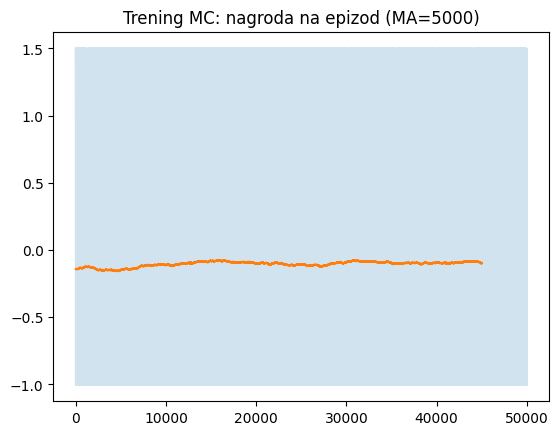

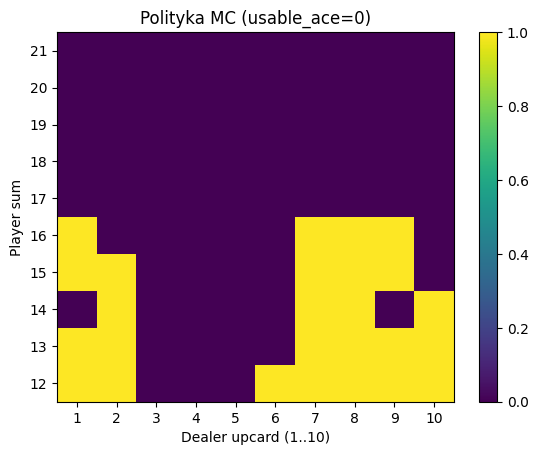

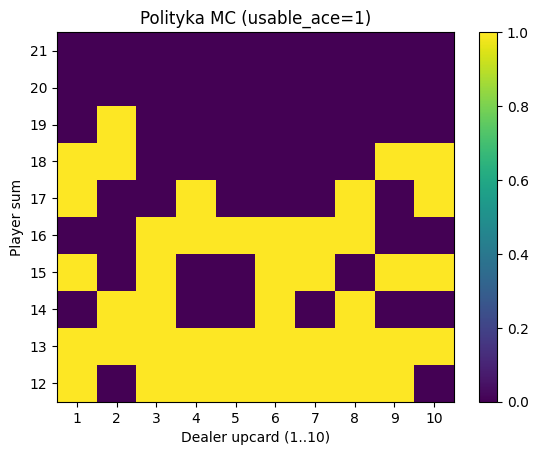

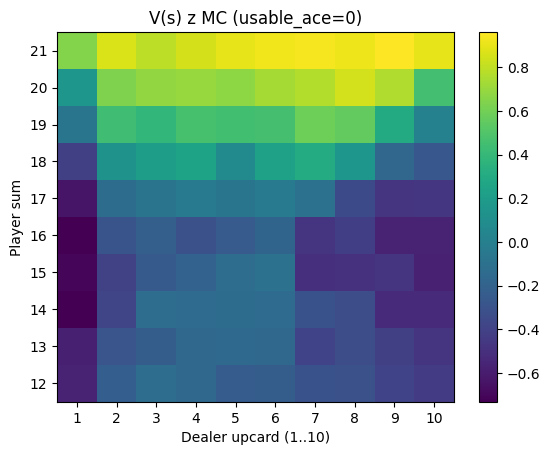

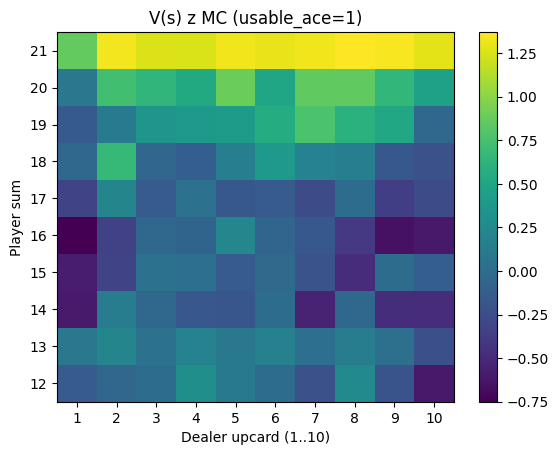

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(x, w):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w, dtype=np.float32)/w, mode='valid')

rewards = np.asarray(rewards_history, dtype=np.float32)
plt.figure()
plt.plot(rewards, alpha=0.2)
plt.plot(moving_avg(rewards, 5000))
plt.title('Trening MC: nagroda na epizod (MA=5000)')
plt.show()

def plot_policy_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))
    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            state = (s, d, bool(usable_ace))
            grid[i, j] = int(np.argmax(Q[state]))
    plt.figure()
    plt.imshow(grid, origin='lower', aspect='auto')
    plt.title(f'Polityka MC (usable_ace={usable_ace})')
    plt.xlabel('Dealer upcard (1..10)')
    plt.ylabel('Player sum')
    plt.xticks(np.arange(len(dealers)), list(dealers))
    plt.yticks(np.arange(len(sums)), list(sums))
    plt.colorbar()
    plt.show()

def plot_value_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))
    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            state = (s, d, bool(usable_ace))
            grid[i, j] = float(np.max(Q[state]))
    plt.figure()
    plt.imshow(grid, origin='lower', aspect='auto')
    plt.title(f'V(s) z MC (usable_ace={usable_ace})')
    plt.xlabel('Dealer upcard (1..10)')
    plt.ylabel('Player sum')
    plt.xticks(np.arange(len(dealers)), list(dealers))
    plt.yticks(np.arange(len(sums)), list(sums))
    plt.colorbar()
    plt.show()

plot_policy_heatmap(0)
plot_policy_heatmap(1)
plot_value_heatmap(0)
plot_value_heatmap(1)
